In [1]:
import math
import pygmt
import imageio
import xarray as xr
import numpy as np
import pyvista as pv
from scripts import stratal as strat
from pyevtk.hl import gridToVTK

import matplotlib
from matplotlib import cm
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

# Extract stratigraphy

We will now look at the recorded stratigraphy. The stratigraphic layer are recorded in gospl as `HDF5` files stored in the output folder as `stratal.XX.pX.h5` where `XX` is the output step and `X` the processor number.


### Stratal record definition

The following information are stored:

+ elevation at time of deposition, considered to be to the current elevation for the top stratigraphic layer `stratZ`.
+ thickness of each stratigrapic layer `stratH` accounting for both erosion & deposition events.
+ porosity of coarse sediment `phiS` in each stratigraphic layer computed at center of each layer.

We will use the `stratal.py` Python class to extract the information above. It requires the following arguments:

+ `path`: the path to the input file
+ `filename`: the name of the input file
+ `layer`: the stratal file you wish to output

In [2]:
# We pick the last step
step = 18 

# Load the function and specify the input file
strati = strat.stratal(path='./', filename='snedden.yml', layer=step, model='utm')

# Read the stratigraphic dataset
strati.readStratalData()

# Interpolate the spherical dataset on a UTM regular grid
# by specifying the desired resolution and interpolation neighbours
strati.buildUTMmesh(res=10000., nghb=3)

Created sedimentary layers: 18
Number of sedimentary layers: 36
Start building regular stratigraphic arrays
Percentage of arrays built : [####################] 100.0% DONE


### Extracting the map for the region

In [3]:
# Smoothing values
sigma=0.1

We now specify the stratigraphic values to extract 

In [4]:
xo = strati.x.min()
xm = strati.x.max()
yo = strati.y.min()
ym = strati.y.max()
lon = np.linspace(xo, xm, strati.nx)
lat = np.linspace(yo, ym, strati.ny)

lons = [0, strati.nx]
lats = [0, strati.ny]
idlat1 = 0
idlat2 = len(lat)
idlon1 = 0
idlon2 = len(lon)

shape = (strati.nx, strati.ny, strati.curLay)
    
# Define the variables shape    
# shape = (idlon2-idlon1,idlat2-idlat1,strati.curLay)

# lon
x = np.empty(shape)
# lat
y = np.empty(shape)
# elevation
z = np.empty(shape)
# elevation at the time of deposition
e = np.empty(shape)
# stratal thickness
h = np.empty(shape)
# layer ID
t = np.empty(shape)
# porosity
ps = np.empty(shape)

# Now let's define the surface elevation
zz = strati.zi[-1, idlat1:idlat2, idlon1:idlon2]
zz = gaussian_filter(zz, sigma)

We use `numba` to speed things up, the function `getVals` will extract the different variables for individual stratigraphic layer.

In [5]:
import numba as nb

@nb.jit(nopython=True)
def getVals(k, idlat1, idlat2, idlon1, idlon2, lon, lat, zz, zi, thu, th, phiSi, topz):
    
    shape = (idlon2-idlon1,idlat2-idlat1)
    lx = np.empty(shape)
    ly = np.empty(shape) 
    lz = np.empty(shape)  
    le = np.empty(shape) 
    lh = np.empty(shape)  
    lps = np.empty(shape)  
    lt = np.empty(shape) 
    
    for j in range(shape[1]):
        for i in range(shape[0]):
            lx[i, j] = lon[i+idlon1]
            ly[i, j] = lat[j+idlat1]  
            if topz is None:
                lz[i, j] = zz[j, i]
            else:
                lz[i, j] = topz[i, j] - thu[j, i]
            le[i, j] = zi[j, i]
            lh[i, j] = th[j, i]
            lps[i, j] = phiSi[j, i]
            lt[i, j] = k
    
    return lx, ly, lz, le, lh, lps, lt

Looping over each layer we extract the information for the desired region:

In [6]:
for k in range(strati.curLay - 1, -1, -1):
    
    if sigma > 0:
        th = gaussian_filter(strati.thi[k, idlat1:idlat2, idlon1:idlon2], sigma)
    th[th < 0] = 0.0
    if k < strati.curLay - 1:
        if sigma > 0:
            thu = gaussian_filter(strati.thi[k + 1, idlat1:idlat2, idlon1:idlon2], sigma)
        thu[thu < 0] = 0.0
    else:
        thu = None
    zi = strati.zi[k, idlat1:idlat2, idlon1:idlon2]
    phiSi = strati.phiSi[k, idlat1:idlat2, idlon1:idlon2]
    
    if k == strati.curLay - 1:
        topz = None
    else:
        topz = z[:, :, k + 1] 
        
    ( x[:, :, k], y[:, :, k], z[:, :, k], 
     e[:, :, k], h[:, :, k], ps[:, :, k], 
     t[:, :, k] 
    ) = getVals(k, idlat1, idlat2, idlon1, idlon2,
                lon, lat, zz, zi, thu, th, phiSi, topz)

We save the dataset as a `vtk` file:

In [7]:
gridToVTK(
            'unconstrainedstrat'+str(step),
            x,
            y,
            z,
            pointData={"dep elev": e, "th": h, "layID": t, "phiC": ps,},
        )

'/Users/getafix/workspace/Gospl_GOM-main/unconstrainedstrat18.vts'

## Plotting cross-sections on a map

We first load the surface dataset:

In [8]:
dataset = xr.open_dataset('model.nc')

Let's plot the position of the cross-sections we want to do: 

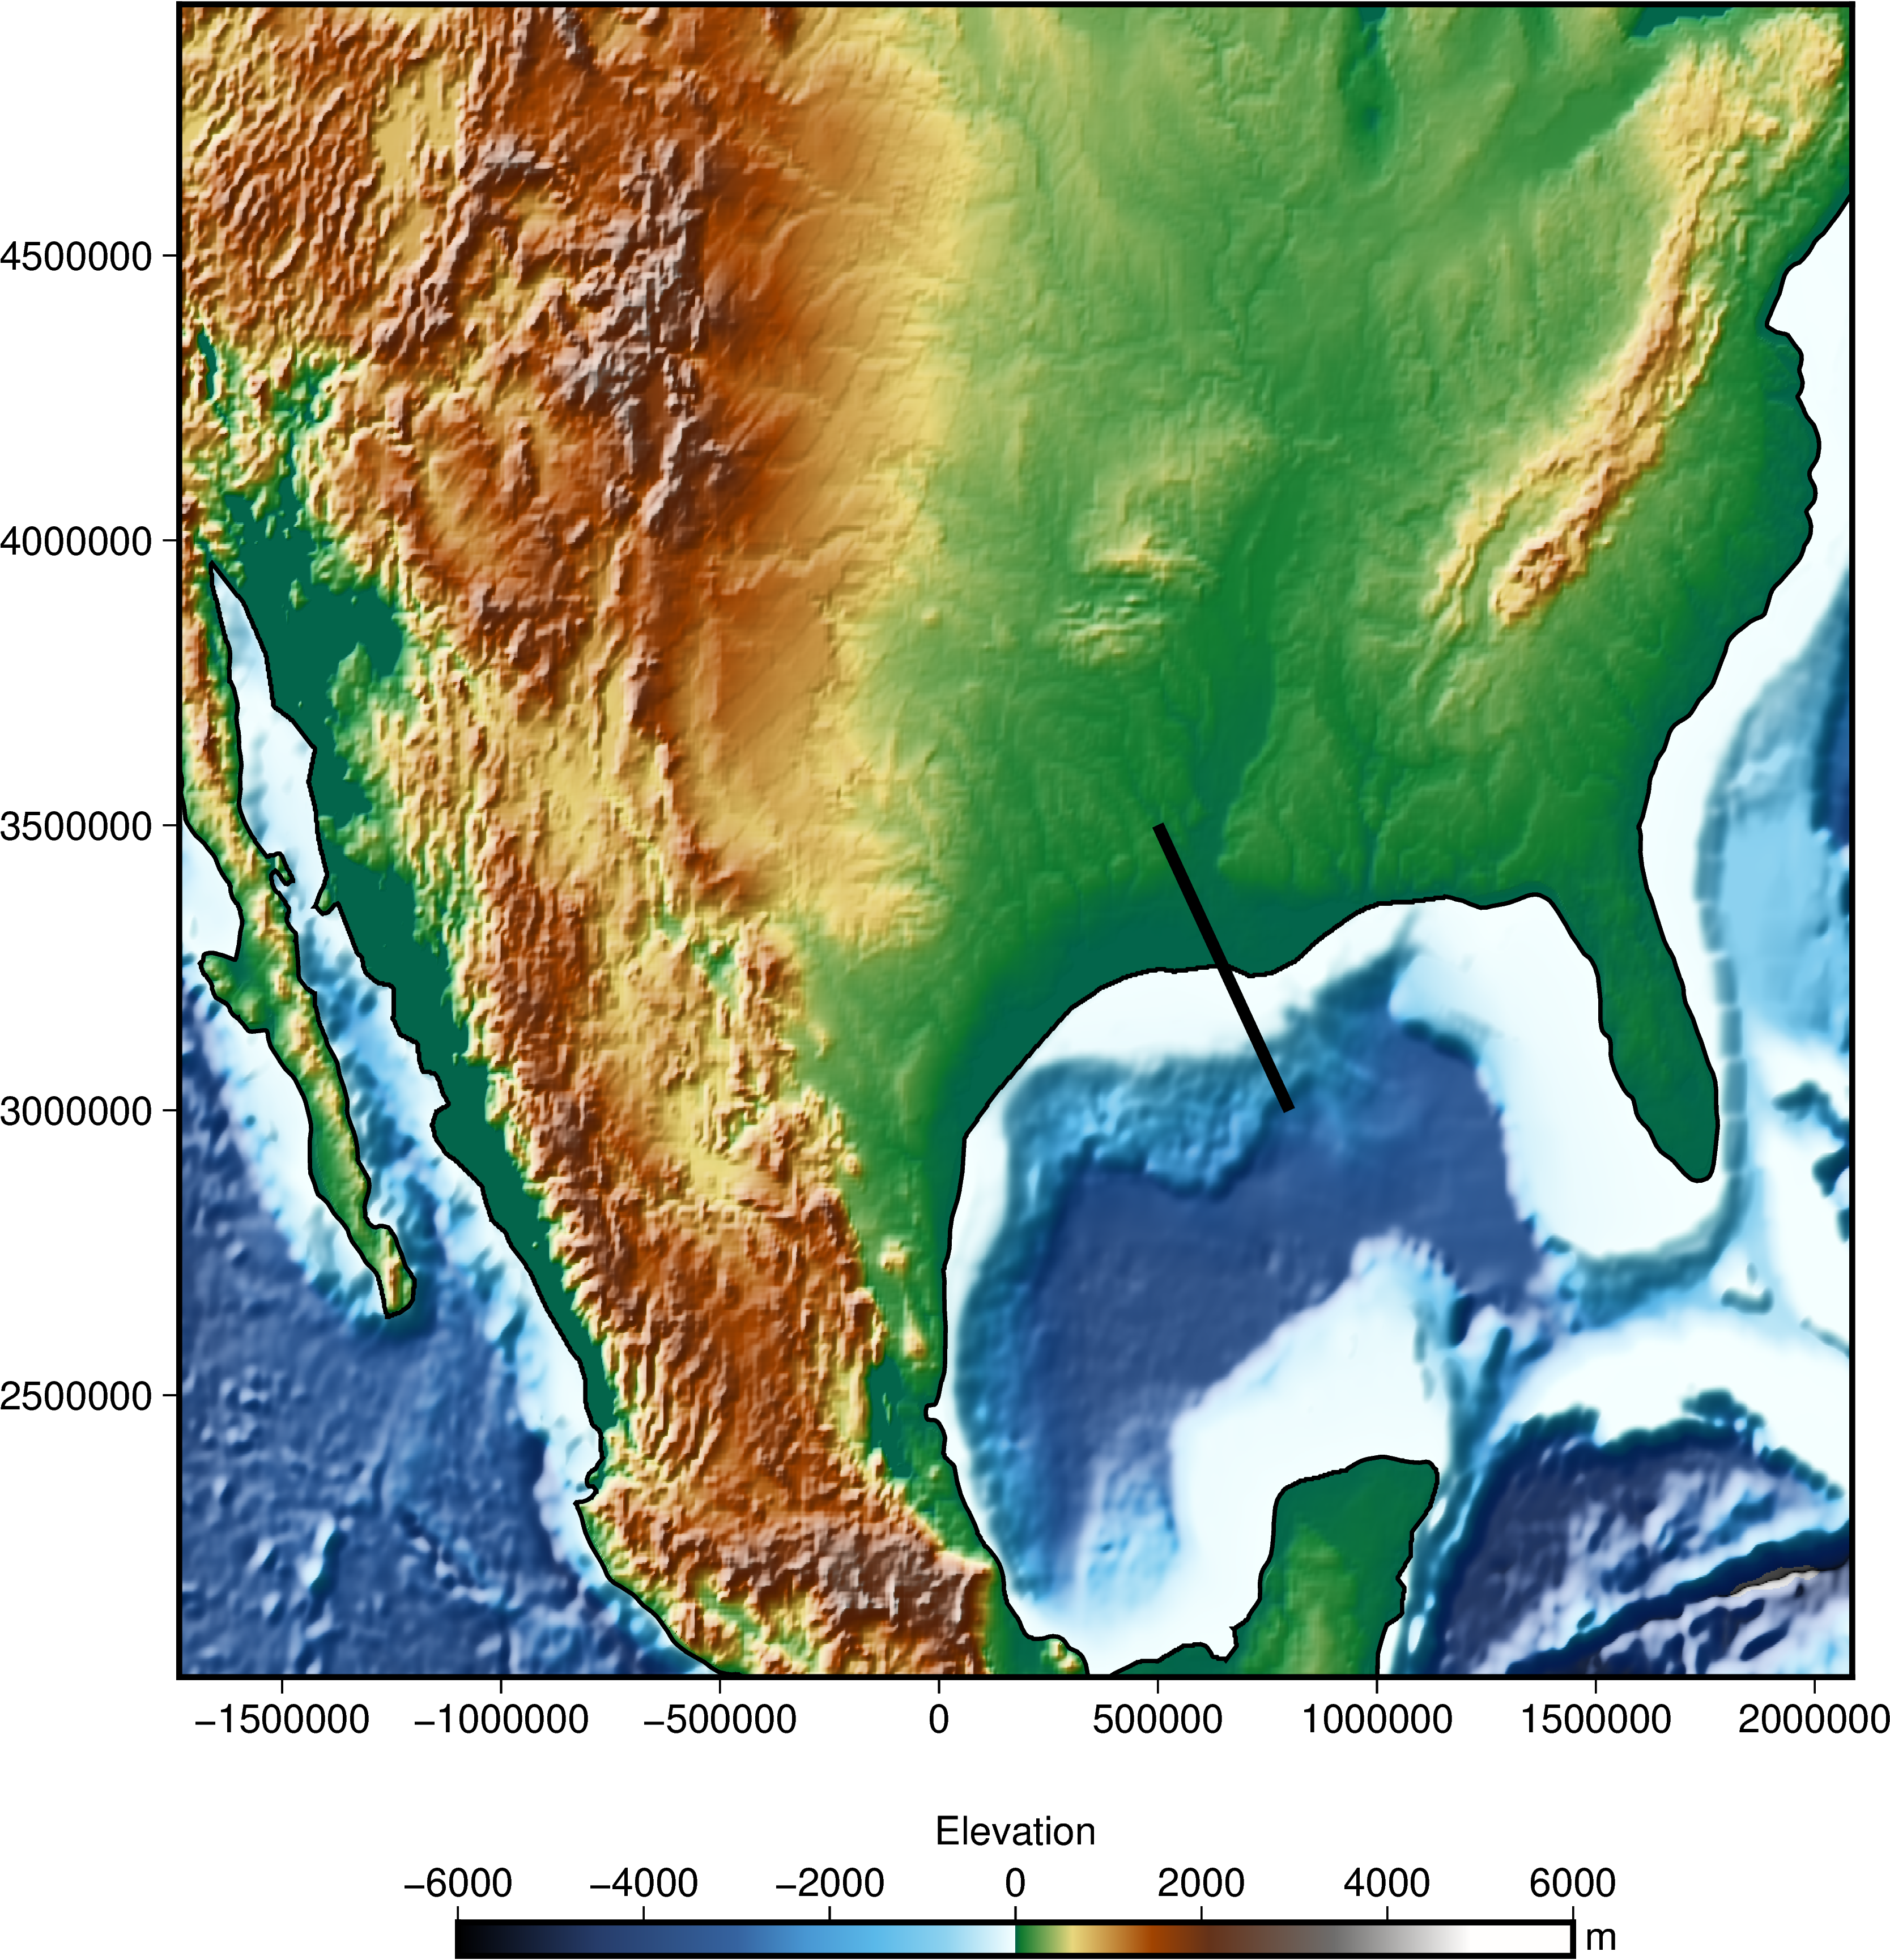

In [9]:
fig = pygmt.Figure()
with pygmt.config(FONT='10p,Helvetica,black'):
    pygmt.makecpt(cmap="geo", series=[-6000, 6000]) 
    fig.grdimage(dataset.topo0, shading=True, frame='a')
    fig.grdcontour(interval=0.1, grid=dataset.topo0, limit=[-0.1e-6, 0.1e-6], pen='1.p')
    fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")
    fig.plot(x=[500000,800000], y=[3500000,3000000], pen="3p,black")
fig.show(dpi=500, width=500)

Now let's load the stratigraphic data that was created in the first section of this notebook:

In [10]:
step = 18 
vtsfile = 'unconstrainedstrat'+str(step)+'.vts'

# read the data
grid = pv.read(vtsfile)

In [11]:
bounds = grid.bounds[:4]
print('lon extent',bounds[0],bounds[1])
print('lat extent',bounds[2],bounds[3])

lon extent 0.0 5444101.0
lat extent -2.561137080192566e-09 3461909.5


To do some longitudinal or latitudinal cross sections, we first create a function (`getCrossData`) that takes the variables from the stratigraphic file along a line:

In [12]:
def getCrossData(slice, sealvl=0):
    
    pts = np.asarray(slice.points)
    cell_indices = slice.faces
    cell_node_ids = cell_indices.reshape(-1, 5)[:,1:5].ravel()
    cells = slice.points[cell_node_ids]
    
    layID = np.asarray(slice.point_data['layID'])
    maxLay = int(layID.max()+1)
    nbpoints = int(len(layID)/maxLay)
    slcShape = (maxLay,nbpoints)
    
    Xpts = pts[:,0].reshape(slcShape)
    Ypts = pts[:,1].reshape(slcShape)
    Zpts = pts[:,2].reshape(slcShape)
    
    porosity = np.asarray(slice.point_data['phiC']).reshape(slcShape)
    depZ = np.asarray(slice.point_data['dep elev']).reshape(slcShape)
    thlay = np.asarray(slice.point_data['th']).reshape(slcShape)
    
    oceanIDs = np.where(Zpts[-1,:]<sealvl)[0]
    ocean = Zpts[-1,:].copy()
    ocean[oceanIDs] = sealvl
    
    return [maxLay,Xpts,Ypts,Zpts,ocean,porosity,depZ,thlay]

#### Along a line

In [13]:
# Distance in degree between the 2 coordinates
ptA = (500000, 800000, 0.0)
ptB = (3500000, 3000000, 0.0)
res = 50000. 
distCross = math.dist(ptA, ptB)
nbpts = int(distCross/res) + 1

Get the coordinates of the points that form a line between these 2 points:

In [14]:
# Line coordinates
line = pv.Line(pointa=ptA, pointb=ptB, resolution=nbpts)

# Slice the dataset along this line
slice = grid.slice_along_line(line)

Get the variables from the stratigraphic record for this line

In [15]:
dataCross = getCrossData(slice, sealvl=0)

In [16]:
clon = dataCross[1][0]
clat = dataCross[2][0]

cptNb = len(clon)
distSection = np.zeros(cptNb)

for k in range(1,cptNb):
    dist = math.dist((clon[k-1],clat[k-1],0.), (clon[k],clat[k],0.))
    distSection[k] += distSection[k-1] + dist
    
distSec = np.repeat(distSection, dataCross[1].shape[0], axis=0)
distSec = distSec.reshape((dataCross[1].shape[1],dataCross[1].shape[0])).T

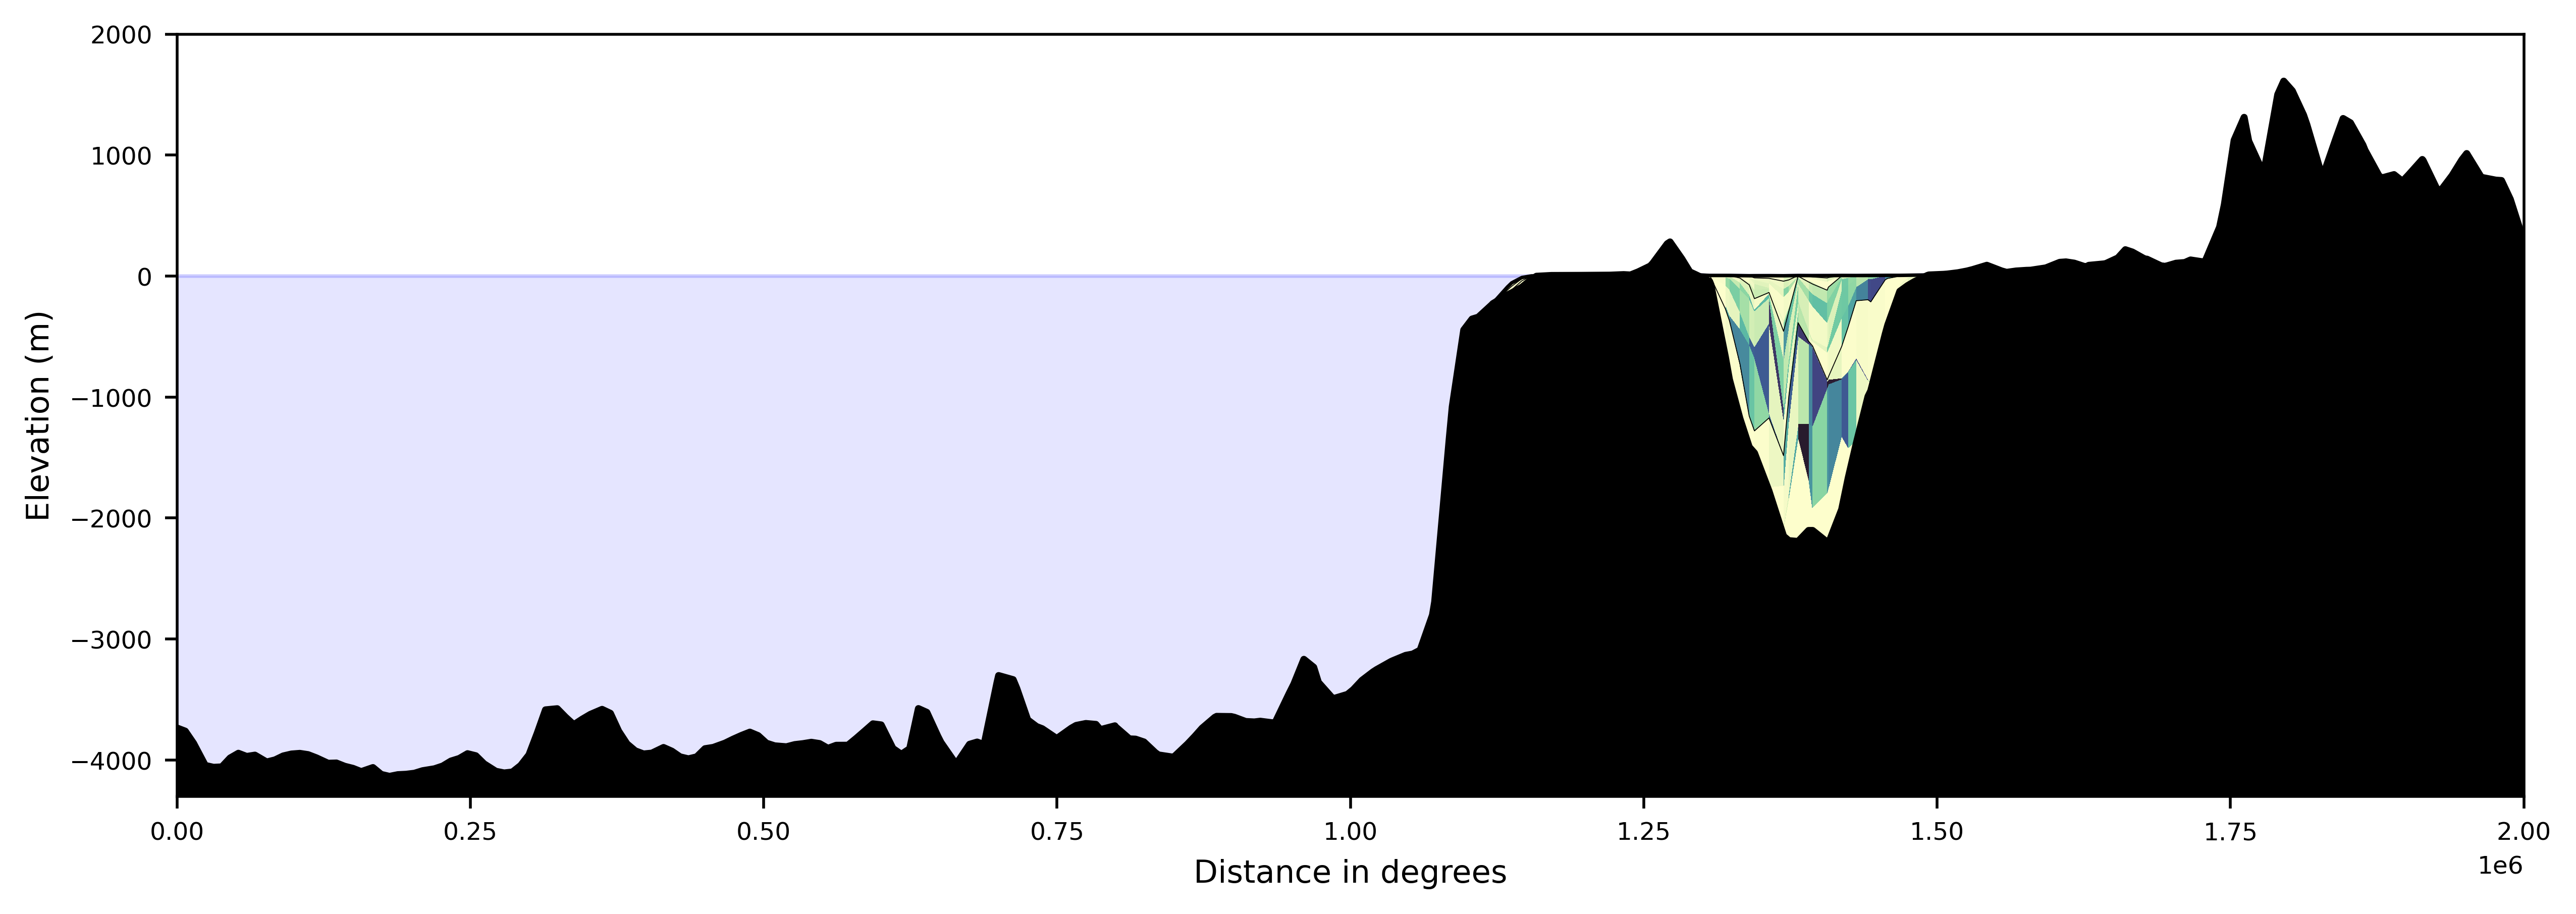

In [18]:
mLay = dataCross[0]
x = distSec
y = dataCross[3]
o = dataCross[4]
v = dataCross[-1]
cmap = cmo.cm.deep

fig, ax = plt.subplots(figsize=(12,4), dpi=500)

plt.plot(x[0,:], o, c='blue', alpha=0.1, lw=1,zorder=0)
plt.fill_between(x[-1,:], y[-1,:], o, color='blue', alpha=0.1,zorder=1)

for k in range(0,mLay,5):
    if k == 0:
        plt.plot(x[k,:], y[k,:],c='k',lw=2,zorder=10)
    else:
        plt.plot(x[k,:], y[k,:],c='k',lw=0.25,zorder=10)
    
pc = ax.pcolormesh(x, y, v[:-1, :-1], shading='auto', zorder=3, cmap=cmap) #, vmin=-500,vmax=500)

plt.plot(x[k,:], y[-1,:],c='k',lw=1,zorder=10)

# pc=ax.pcolormesh(X,Y,Z,vmin=0.3,vmax=0.6)
# fig.colorbar(pc)

plt.fill_between(x[k,:], -20000, y[0,:], color='k', alpha=1,zorder=5)
ax.set_xlim(0, 2.e6)
ax.set_ylim(-4300, 2000)
plt.xlabel('Distance in degrees', fontsize=9)
plt.ylabel('Elevation (m)', fontsize=9)
# plt.savefig('crossLine.png', bbox_inches='tight', dpi=500)
plt.show()